In [36]:
import numpy as np
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

import codecs
import glob
from tqdm.notebook import tqdm
import itertools
from collections import Counter
import os
import sys


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pickle

#shut down warnings
import warnings
warnings.filterwarnings('ignore')

## Paper Figures

This notebook allows for reconstructing most of paper figures (except of illustrations figures) </br>

### Load data
First you'll need to load the data for generating the figures.</br>

The data needed can be found in the supplementary material provided with the paper.</br>

Download instruction found in main Readme file

In [60]:
w = pd.read_csv("models_and_data/figures_data.csv")
known_system_table = pd.read_csv("models_and_data/novel_defense_mapping/defense_hypothetical_system_predictions.csv")
rarefaction_path = "models_and_data/rarefaction/*pkl"

In [22]:
labels = ['Prokaryotic defense system', 'Secretion system',
       'Benzoate degradation', 'Oxidative phosphorylation',
       'Two-component system', 'Ribosome',
       'Porphyrin and chlorophyll metabolism', 'Energy metabolism',
       'Other', 'Amino sugar and nucleotide sugar metabolism']

### Figure 2

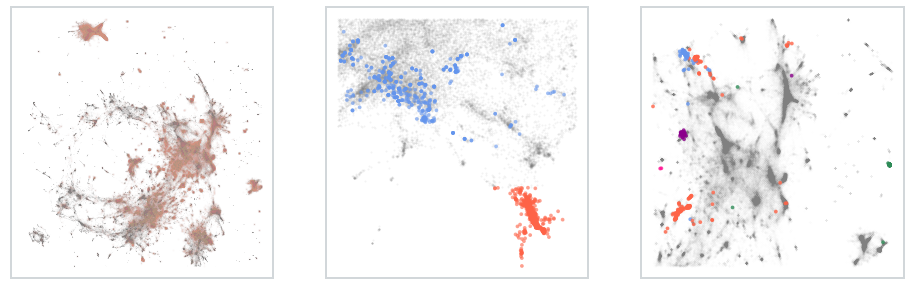

In [44]:
f, ax = plt.subplots(1,3,figsize=(16, 5))

# All space
all_space = w[(w['x'] <= 8) & (w['y'] < 19) & (w['y'] >= 2) & (w['x'] > -10)]
sns.scatterplot(x='x', y='y', data=all_space[all_space['label'] == 'unknown'],color='grey',
                alpha=0.01, linewidth=0, s=2, ax=ax[0], legend=False)
sns.scatterplot(x='x', y='y', data=all_space[all_space['label']!= 'unknown'] ,color='#D29380',
                alpha=0.05, linewidth=0, s=4, ax=ax[0], legend=False)


# CRISPR zoom-in
crspr = w[(w['x'] > -2) & (w['x'] < -0.4) & (w['y'] > 2) & (w['y'] <4.4)]
crspr["label"] = crspr.apply(lambda w: "CRISPR" if (w['x'] > -1) and (w['x'] < -0.4) and
                             (w['y'] > 0) and (w['y'] <2.8) else w['label'], axis=1)
crspr['label'] = crspr.apply(lambda w: "Prokaryotic defense system" if w["hmm_type"] == "defense" else w["label"], axis=1)
cmap = sns.color_palette(['cornflowerblue', 'tomato'])
sns.scatterplot(x='x', y='y', data=crspr[crspr["hmm_type"] != 'defense'],
                color='grey', alpha=0.09, linewidth=0, s=4, ax=ax[1], label="Non-Defense", legend=False)
sns.scatterplot(x='x', y='y', data=crspr[crspr["label"].isin(["Prokaryotic defense system", "CRISPR"])],
                palette=cmap, alpha=0.6, linewidth=0, s=14, ax=ax[1],hue='label',
                label="Prokaryotic defense system", legend=False)


# Secretion zoom-in
secr = w[(w['x'] > -.5) & (w['x'] < 8.5) & (w['y'] > 7) & (w['y'] < 14)]
cmap = sns.color_palette(["tomato", "darkmagenta" ,"cornflowerblue","seagreen","deeppink"])
sns.scatterplot(x='x', y='y', data=secr[(secr['label'] == 'unknown')],color='grey',
                alpha=0.009, linewidth=0, s=4, ax=ax[2], legend=False)
sns.scatterplot(x='x', y='y', data=secr[(secr["label"] == "Secretion system") & (secr["secretion_type"] != "other")],
                    hue='secretion_type',palette=cmap, alpha=0.8, linewidth=0, s=14, ax=ax[2], legend=False)

ax[0].set_xlabel("UMAP1")
ax[1].set_xlabel("UMAP1")
ax[2].set_xlabel("UMAP1")

ax[0].set_ylabel("UMAP2")
ax[1].set_ylabel("")
ax[2].set_ylabel("")

for i in range(3):
    ax[i].axes.get_xaxis().set_visible(False)
    ax[i].axes.get_yaxis().set_visible(False)
    plt.setp(ax[i].spines.values(), color="#D2D7DA", lw=2)

plt.savefig("figure2.png", format='png', dpi=350)

### Figure 4

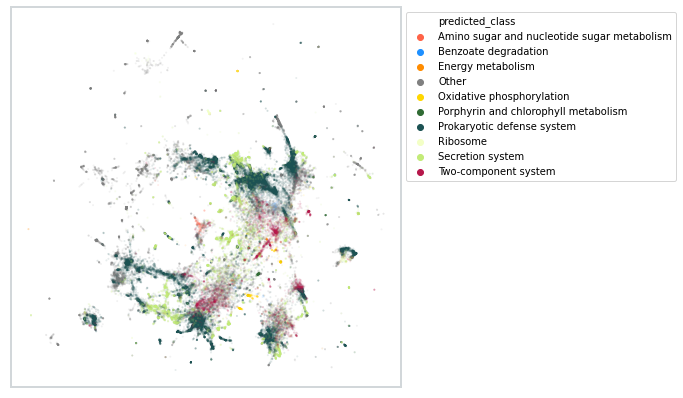

In [45]:
# Figure 4a
# candidates
f, ax = plt.subplots(figsize=(7, 7))

all_space = w[(w['x'] <= 10) & (w['y'] >= 1.2)]
all_space = all_space[(all_space['predicted_class'].isin(labels))].sort_values(by="predicted_class")
cmap = sns.color_palette(['tomato', 'dodgerblue', 'darkorange', 'grey', 'gold', '#306B34','#1C5253', '#F3FFC6', '#C3EB78', '#B6174B'])
sns.scatterplot(x='x', y='y', data=all_space ,hue='predicted_class', palette=cmap,
                alpha=0.1, linewidth=0, s=4, ax=ax)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.setp(ax.spines.values(), color="#D2D7DA", lw=2)
plt.legend(bbox_to_anchor=[1,1])

plt.savefig("candidates.png", format='png', dpi=350,bbox_inches="tight")

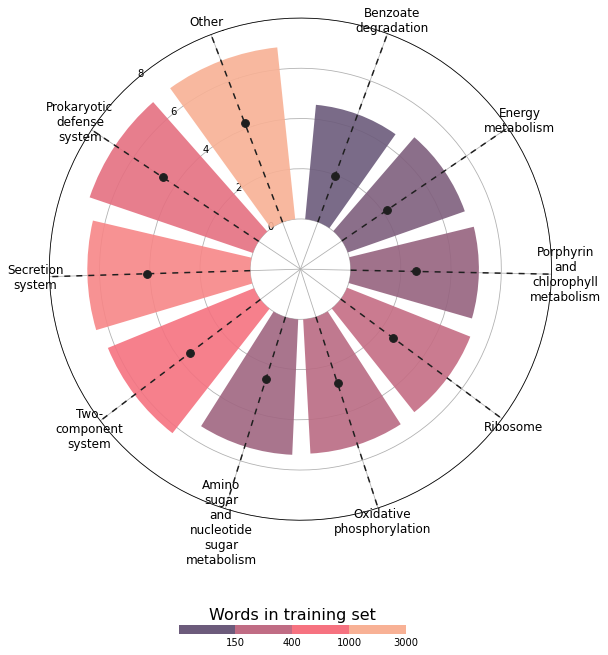

In [53]:
# Figure 4b

# This figure was adjusted from :
# https://www.python-graph-gallery.com/web-circular-barplot-with-matplotlib


w_preds = w[(w['label'].isin(labels)) | (w['predicted_class'].isin(labels))]
w_preds["class"] = w_preds.apply(lambda x: x['label'] if x['label'] != 'unknown' else x['predicted_class'], axis=1)
w_preds['hypothetical'] = w_preds['word'].apply(lambda x: "hypo.clst." in x)
grp = w_preds.groupby(['class', 'hypothetical']).agg({'word': pd.Series.nunique, 'word_count': sum}).reset_index()

grp['word_count_log'] = np.log10(grp['word_count'])
grp['word_log'] = np.log10(grp['word'])

grp_hypo = grp[grp['hypothetical'] == True]
grp_known = dict(grp[grp['hypothetical'] != True][["class", "word_log"]].values)
grp_known['Other'] = 3.5
grp_hypo['n'] = grp_hypo['class'].apply(lambda x: grp_known[x])

df_sorted = grp_hypo.sort_values("word_count", ascending=False)

# Values for the x axis
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sorted), endpoint=False)
LENGTHS = df_sorted["word_count_log"].values
MEAN_GAIN = df_sorted["word_log"].values
REGION = df_sorted["class"].values
TRACKS_N = df_sorted["n"].values

GREY12 = "#1f1f1f"
COLORS = ["#6C5B7B", "#C06C84", "#F67280", "#F8B195"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)
norm = mpl.colors.Normalize(vmin=TRACKS_N.min(), vmax=TRACKS_N.max())

COLORS = cmap(norm(TRACKS_N))

fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-2, 8)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.52, zorder=10)
ax.vlines(ANGLES, 0, 8, color=GREY12, ls=(0, (4, 4)), zorder=11)

ax.scatter(ANGLES, MEAN_GAIN, s=60, color=GREY12, zorder=11)


REGION = ["\n".join(wrap(r, 5, break_long_words=False)) for r in REGION]
# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(REGION, size=12)


cbaxes = inset_axes(
    ax,
    width="100%",
    height="100%",
    loc="center",
    bbox_to_anchor=(0.325, 0.1, 0.35, 0.01),
    bbox_transform=fig.transFigure  # Note it uses the figure.
)

# Create a new norm, which is discrete
bounds = [1, 150, 400, 1000, 3000]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    cax=cbaxes,  # Use the inset_axes created above
    orientation="horizontal",
    ticks=[150, 400, 1000, 3000]
)

cb.outline.set_visible(False)
cb.ax.xaxis.set_tick_params(size=0)
cb.set_label("Words in training set", size=16, labelpad=-40)

plt.savefig("predictions_cbar.png", format='png', dpi=350)

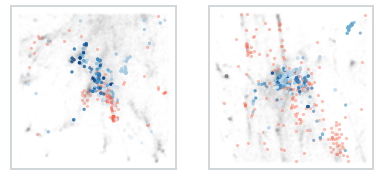

In [57]:
# Figure 4c
f, ax = plt.subplots(1,2,figsize=(6.5, 3))

all_space1 = w[(w['x'] <= -0.5) & (w['y'] >= 3) & (w['x'] > -3) & (w['y'] <= 4.5)]
sns.scatterplot(x='x', y='y', data=all_space1[(all_space1['label'] == 'unknown') &
                                             (all_space1['hmm_type'] != 'defense')],color='grey',
                alpha=0.008, linewidth=0, s=8, ax=ax[0], legend=False)
sns.scatterplot(x='x', y='y', data=all_space1[all_space1['label'] == 'Prokaryotic defense system'] ,color='tomato',
                alpha=0.4, linewidth=0, s=10, ax=ax[0], legend=False)
sns.scatterplot(x='x', y='y', data=all_space1[all_space1['hmm_type'] == 'defense'] ,hue='system', palette='Blues',
                alpha=0.4, linewidth=0, s=10, ax=ax[0], legend=False)

all_space2 = w[(w['x'] > 0) & (w['y'] >= 11) & (w['x'] < 4) & (w['y'] <= 12.5)]
sns.scatterplot(x='x', y='y', data=all_space2[(all_space2['label'] == 'unknown') &
                                             (all_space2['hmm_type'] != 'defense')],color='grey',
                alpha=0.008, linewidth=0, s=8, ax=ax[1], legend=False)
sns.scatterplot(x='x', y='y', data=all_space2[all_space2['label'] == 'Prokaryotic defense system'] ,color='tomato',
                alpha=0.4, linewidth=0, s=10, ax=ax[1], legend=False)
sns.scatterplot(x='x', y='y', data=all_space2[all_space2['hmm_type'] == 'defense'] ,hue='system', palette='Blues',
                alpha=0.4, linewidth=0, s=10, ax=ax[1], legend=False)

for i in [0,1]:
    ax[i].axes.get_xaxis().set_visible(False)
    ax[i].axes.get_yaxis().set_visible(False)
    plt.setp(ax[i].spines.values(), color="#D2D7DA", lw=2)

plt.savefig("prokaryotic_zoomin.png", format='png', dpi=350)

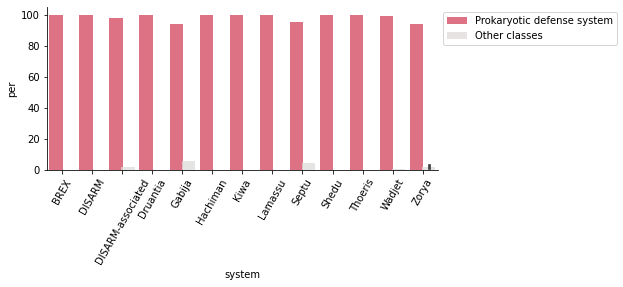

In [58]:
# Figure 4d
f, ax = plt.subplots(figsize=(7, 3))

plt_data = known_system_table[(known_system_table['system'] != 'unknown')]
plt_data["class"] = plt_data["predicted_class"].apply(lambda x: x if "Proka" in x else "Other classes")


sns.barplot(x='system', y='per', data=plt_data, hue='class', palette=['#EB2B4C', '#DFDBD9'],alpha=0.75, ax=ax)
_ = plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=[1,1])

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .45)
sns.despine()

plt.savefig("predictions_bar.pdf", format='pdf', bbox_inches="tight")

(1000.0, 95100.0)

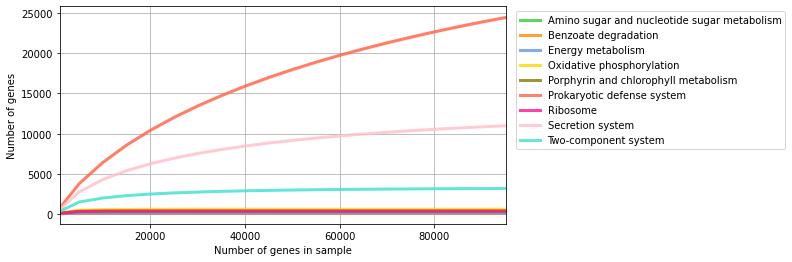

In [59]:
# Figure 4e
boots = [pd.read_pickle(f) for f in glob.glob(rarefaction_path)]
boots[1]['n_genes'] = boots[0]['n_genes']
boots[2]['n_genes'] = boots[0]['n_genes']

df = pd.concat(boots)

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['limegreen', 'darkorange', 'cornflowerblue', 'gold', 'olive', 'tomato', 'deeppink', 'pink', 'turquoise']

for c, cl in zip(colors, df.sort_values(by='function')["function"].unique()):
    class_data = df[df["function"] == cl]
    ax.plot(class_data['n_genes'], class_data['uniq_genes_mean'], color=c,
            label=cl, lw=3, alpha=.8)
    ax.fill_between(class_data['n_genes'], class_data['lower_q'], class_data['upper_q'], color=c, alpha=.1)

ax.grid(True)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlabel("Number of genes in sample")
plt.ylabel("Number of genes")
plt.xlim(1000, df['n_genes'].max())

plt.savefig("rarefaction.pdf", format='pdf', dpi=350)
